# Jupyter Notebook for Data Visualization of HTS 2025 Scratch Wounds Datasets
## Author: Anish Vasan
## Date: 2025/08/23

## Notebook Setup

### Imports

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import scienceplots

In [36]:
plt.style.use(['science', 'nature'])
plot_params = {
    "figure.dpi": "200",
    "axes.labelsize": 14,
    "axes.linewidth": 1.5,
    "axes.titlesize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.title_fontsize": 16,
    "legend.fontsize": 16,
    "xtick.major.size": 3.5,
    "xtick.major.width": 1.5,
    "xtick.minor.size": 2.5,
    "xtick.minor.width": 1.5,
    "ytick.major.size": 3.5,
    "ytick.major.width": 1.5,
    "ytick.minor.size": 2.5,
    "ytick.minor.width": 1.5,
}
plt.rcParams.update(plot_params)

sns.set_style("ticks")

#matplotlib inline

### Functions


#### Data Preparation Functions


In [37]:
def process_excel_files(file_name_fn, file_path_fn)->dict:
    """Process a list of Excel files generate DataFrames."""
    print(f"Processing file: {file_path_fn}")
    data = pd.read_excel(file_path_fn, sheet_name=None)

    # Load required sheets, dropping unnecessary columns
    condition_map = data['condition_map']
    filter = data['Filter']
    wound_area = data['Plate 1 - Wound Width'].drop(columns=['Time'])

    # Drop columns in wound_area based on filter
    cols_to_drop = filter[filter['Exclude'] == 1]
    print(f"Dropping columns: {cols_to_drop['Well'].values} from {file_name_fn}")
    wound_area_filtered = wound_area.drop(columns=cols_to_drop['Well'].values).dropna(axis=0, how='all')

    # Drop rows that contain strings (non-numeric rows)
    wound_area_filtered = wound_area_filtered[pd.to_numeric(wound_area_filtered.iloc[:,0], errors='coerce').notnull()]

    # Extract time index and ensure it matches the filtered wound area DataFrame. The time_index is provided as HH:MM:SS as time elapsed from the start of the experiment.
    time_index = data['Plate 1 - Wound Width']['Time'].iloc[wound_area_filtered.index]

    # Identify outliers based on major, minor axis lengths and wound area at time 0
    outlier_wells, bounds = identify_outliers(
        wound_area_filtered.iloc[0]
    )
    print(f"Wells outside bounds for {file_name_fn}: \n{[key for key in outlier_wells.keys()]}")
    # Plot wound area for the first time point and outlier bounds
    plot_wound_area(wound_area_filtered.iloc[0],bounds, outlier_wells, file_name_fn)

    # Create condition dictionary from condition map and filtered wound area
    dict_conditions = create_dict_condition(condition_map, wound_area_filtered)

    # Normalize wound area data
    wound_area_normalized = normalize_wound_area(wound_area_filtered)

    # Return processed data
    return {
        'dict_condition': dict_conditions,
        'wound_area_filtered': wound_area_filtered,
        'wound_area_normalized': wound_area_normalized,
        'outlier_wells': outlier_wells,
        'time_index': time_index,
    }

def create_dict_condition(condition_map_input, wound_area_filtered_input)->dict:
    """Create a dictionary of conditions and their corresponding wells."""
    dict_condition_fn = {}
    for index, row in condition_map_input.iterrows():
        condition_name = row['Condition']
        well_name_fn = row['Well']

        # Check if the well name exists in wound_area_filtered columns
        if well_name_fn in wound_area_filtered_input.columns:
            if condition_name not in dict_condition_fn:
                dict_condition_fn[condition_name] = []
            dict_condition_fn[condition_name].append(well_name_fn)
    return dict_condition_fn

def drop_outliers(extracted_data_input):
    # Drop all outlier wells from the wound_area_normalized DataFrame
    for file_name_fn, data_fn in extracted_data_input.items():
        outlier_wells_fn = data_fn['outlier_wells']
        wound_area_normalized_fn = data_fn['wound_area_normalized']
        if outlier_wells_fn:
            print(f"Dropping outlier wells for {file_name_fn}: {list(outlier_wells_fn.keys())}")
            # Create a list of columns to drop
            columns_to_drop_fn = [col for col in wound_area_normalized_fn.columns if any(well in col for well in outlier_wells_fn.keys())]
            # Drop the columns from the DataFrame
            data_types = ['wound_area_normalized', 'wound_area_filtered']
            for data_type in data_types:
                for col in columns_to_drop_fn:
                    if col in data_fn[data_type].columns:
                        data_fn[data_type].drop(columns=col, inplace=True)
                extracted_data_input[file_name_fn][data_type]= data_fn[data_type]

            # Drop the outlier wells from the dict_condition
            dict_condition_fn = data_fn['dict_condition']
            for condition_fn, wells_fn in dict_condition_fn.items():
                dict_condition_fn[condition_fn] = [well for well in wells_fn if well not in columns_to_drop_fn]
            extracted_data_input[file_name_fn]['dict_condition'] = dict_condition_fn


    return extracted_data_input

def combine_conditions(extracted_data_input)->tuple:
    """Combine conditions from processed data into a single dictionary with DataFrames."""
    dict_combined_condition_fn = {}
    dict_counter = {}
    for file_name, data_fn in extracted_data_input.items():
        condition_dict_fn = data_fn['dict_condition']
        wound_area_normalized_fn = data_fn['wound_area_normalized']

        for condition_fn, wells in condition_dict_fn.items():
            if condition_fn not in dict_combined_condition_fn:
                # Initialize with the first file's data for this condition
                dict_combined_condition_fn[condition_fn]={}
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'] = wound_area_normalized_fn[wells].copy()

                #Rename the columns to include the file name
                new_well_names_fn = [f"{file_name}-{well}" for well in wells]
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'].columns = new_well_names_fn


                # Initialize the dictionary for the new condition in dict_counter
                dict_counter[condition_fn] = {}
                dict_counter[condition_fn]["wells"] = len(wells)
                dict_counter[condition_fn]["experiments"] = 1
            else:
                # Concatenate wells from additional files
                new_data_wa = wound_area_normalized_fn[wells]
                new_data_wa.columns = [f"{file_name}-{well}" for well in wells]
                dict_combined_condition_fn[condition_fn]['wound_area_normalized'] = pd.concat([dict_combined_condition_fn[condition_fn]['wound_area_normalized'], new_data_wa], axis=1)
                dict_counter[condition_fn]["wells"] = dict_counter[condition_fn]["wells"] + len(wells)
                dict_counter[condition_fn]["experiments"] = dict_counter[condition_fn]["experiments"] + 1

    pd_counter_output = pd.DataFrame.from_dict(dict_counter, orient='index')

    return dict_combined_condition_fn, pd_counter_output

def reshape_combined_conditions(extracted_data_input, time_index_input, cell_type_df)->pd.DataFrame:
    """Convert combined condition dictionary to long format DataFrame for seaborn"""
    # Create a mapping from experiment name to cell type
    cell_type_map = pd.Series(
        cell_type_df['cell_type'].values,
        index=cell_type_df['filename']
    ).to_dict()

    # Create a mapping from experiment name to passage number
    passage_map = pd.Series(
        cell_type_df['passage'].values,
        index=cell_type_df['filename']
    ).to_dict()

    # Create a list to hold all the data
    all_data = []
    # Iterate through each condition and its DataFrame
    for experiment_fn, data_fn in extracted_data_input.items():
        wan = data_fn['wound_area_normalized'][:len(time_index_input)].copy()
        wan.index = time_index_input
        waf = data_fn['wound_area_filtered'][:len(time_index_input)].copy()
        waf.index = time_index_input
        combined_wound_areas = pd.concat([wan, waf],
                                         axis=1,
                                         keys=['wound_area_normalized', 'wound_area_pixels'])
        long_wound_areas = combined_wound_areas.stack(level=1,future_stack=True).reset_index()
        long_wound_areas.rename(columns={'level_1': 'well'}, inplace=True)


        merged_df = long_wound_areas
        merged_df['exp'] = experiment_fn
        # Use the map to get the cell type, with a default value for safety
        merged_df['cell_type'] = cell_type_map.get(experiment_fn, 'Unknown')
        merged_df['passage'] = passage_map.get(experiment_fn, 'Unknown')
        condition_lookup = {
            well_fn: cond for cond, wells_fn in data_fn['dict_condition'].items() for well_fn in wells_fn
        }
        merged_df['condition_map'] = merged_df['well'].map(condition_lookup)
        merged_df['well'] =  [experiment_fn + '_' + well_fn for well_fn in merged_df['well']]
        all_data.append(merged_df)
    all_data = pd.concat(all_data, ignore_index=True).rename(columns={'Time': 'time_index'})
    return all_data


#### Data Calculation Functions

In [38]:
def identify_outliers(wa_in)->tuple:
    """Identify outlier wells based on minor and major axis lengths."""
    # Calculate bounds for major and minor axis lengths
    wa_lower_bound, wa_upper_bound = calculate_bounds(wa_in)
    outlier_wells_output = {}
    for i, wa in enumerate(wa_in):
        if wa < wa_lower_bound or wa > wa_upper_bound:
            outlier_wells_output[wa_in.index[i]]= wa
    return outlier_wells_output, (wa_lower_bound, wa_upper_bound)

def calculate_bounds(parameter_input)->tuple:
    """Calculate lower and upper bounds for outlier detection."""
    average = parameter_input.mean()
    iqr = parameter_input.quantile(0.75) - parameter_input.quantile(0.25)
    lower_bound = average - 1.5 * iqr
    upper_bound = average + 1.5 * iqr
    return lower_bound, upper_bound

def normalize_wound_area(wound_area_filtered_input)->pd.DataFrame:
    """Normalize the wound area data to the initial value at time 0."""
    wound_area_normalized_fn = wound_area_filtered_input.copy()
    for col in wound_area_normalized_fn.columns:
        initial_value = wound_area_normalized_fn[col].iloc[0]
        if initial_value != 0:  # Avoid division by zero
            # Print datatypes of initial value and wound_area_normalized_fn[col]
            wound_area_normalized_fn[col] = wound_area_normalized_fn[col] / initial_value
        else:
            wound_area_normalized_fn[col] = np.nan  # Set to NaN if initial value is zero
    return wound_area_normalized_fn

def round_time_to_nearest_half_hour(dt_obj):
    """
    Rounds a datetime.time object to the nearest half hour and return a float.
    """
    total_minutes = dt_obj.hour * 60 + dt_obj.minute
    rounded_minutes = round(total_minutes / 30) * 30
    rounded_hours = rounded_minutes // 60
    rounded_remaining_minutes = rounded_minutes % 60
    return rounded_hours + rounded_remaining_minutes / 60.0


### Plotting Functions

In [39]:
def plot_wound_area(wound_area_input, bounds_input, outlier_wells_input, file_name_input)->None:
    """Plot the wound major vs minor axis lengths at time 0."""

    wa_upper, wa_lower = bounds_input

    # Create DataFrame for seaborn
    scatter_data = pd.DataFrame({
        'wound_area': wound_area_input,
        'well': wound_area_input.index,
        'is_outlier': [well in outlier_wells_input for well in wound_area_input.index]
    })
    # Add numerical index column
    scatter_data['well_index'] = range(len(scatter_data))
    plt.figure(figsize=(10, 6))

    # Create the scatter plot
    ax = sns.scatterplot(
        data=scatter_data,
        x='well_index',
        y='wound_area',
        hue='is_outlier',
        palette={True: 'red', False: 'blue'},
        alpha=1,
        s=50
    )

    # Label the wells that are outside the bounds
    for well in outlier_wells_input:
        wa = outlier_wells_input[well]
        well_idx = scatter_data.loc[scatter_data['well'] == well, 'well_index'].iloc[0]
        plt.annotate(f'{well}', (well_idx, wa), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

    ax.axhline(wa_lower, color='red', linestyle='--', label='Min wa')
    ax.axhline(wa_upper, color='green', linestyle='--', label='Max wa')

    # Plot scatter plot of the axis lengths at first time point
    ax.set_title('Wound Area at T=0')
    ax.set(
        xlabel='well',
        ylabel='Wound Area'
    )
    plt.legend( loc='upper right', title='Outlier Wells', fontsize='small', title_fontsize='medium', frameon=True, fancybox=True)
    plt.savefig(f'wound_axis_lengths_{file_name_input}.svg', format='svg')
    plt.show()

def plot_outlier_wound_areas(outlier_wells_input, wound_area_normalized_input, time_index_input, file_name_input)->None:


    print(f"Plotting outlier wells for {file_name}: {list(outlier_wells_input.keys())}")
    plt.figure(figsize=(12, 8))
    plt.plot(time_index_input, wound_area_normalized_input.mean(axis=1), label='mean', color='black', linewidth=2, alpha=0.8)
    for well_name in outlier_wells_input.keys():
        # Find the full column name in wound_area_normalized that matches the outlier well
        matching_columns = [col for col in wound_area_normalized_input.columns if well_name in col]

        if matching_columns:
            well_column = matching_columns[0]

            plt.plot(time_index_input, wound_area_normalized_input[well_column],
                     label=f"{well_name}", linewidth=2, alpha=0.8)

    plt.xlabel('Time')
    plt.ylabel('Normalized Wound Area')
    plt.title('Time Series of Outlier Wells - Normalized Wound Area')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{file_name_input}_outlier_wells_timeseries.svg', format='svg', dpi=600, bbox_inches='tight')
    plt.show()

## Notebook Operation

### Load Data and Filter for Outliers
#### User Input Required Here:
- Specify the directory and file names
- Define the control group name to compare against
- Pick outlier wells to drop manually if needed


In [40]:
# Define the list of Excel files to process
##** User Input Required **##
dir_parent = 'Z:\\Anish\\Code Analyzed Data\\20250706\\SW'
file_names = [
    #'SWP3.xls',
    #'SWP4.xls',
    'SWP5.xls',
    'SWP6.xls',
    #'SWP7.xls',
]

# You can add more file names to the list as needed.
# If you want to process all files in the directory, you can uncomment the following lines:
#file_names2 = [f for f in os.listdir(dir_parent) if f.endswith('.xlsx')]

# Define the name of the Control Group to compare against
control_group_name = 'DMSO'

Filenames to process: ['SWP5.xls', 'SWP6.xls']
Processing SWP5.xls...
Processing file: Z:\Anish\Code Analyzed Data\20250706\SW\SWP5.xls
Dropping columns: ['G1'] from SWP5
Wells outside bounds for SWP5: 
['A1', 'A4', 'A12', 'C12', 'D3', 'H5', 'H9', 'H10', 'H11', 'H12']


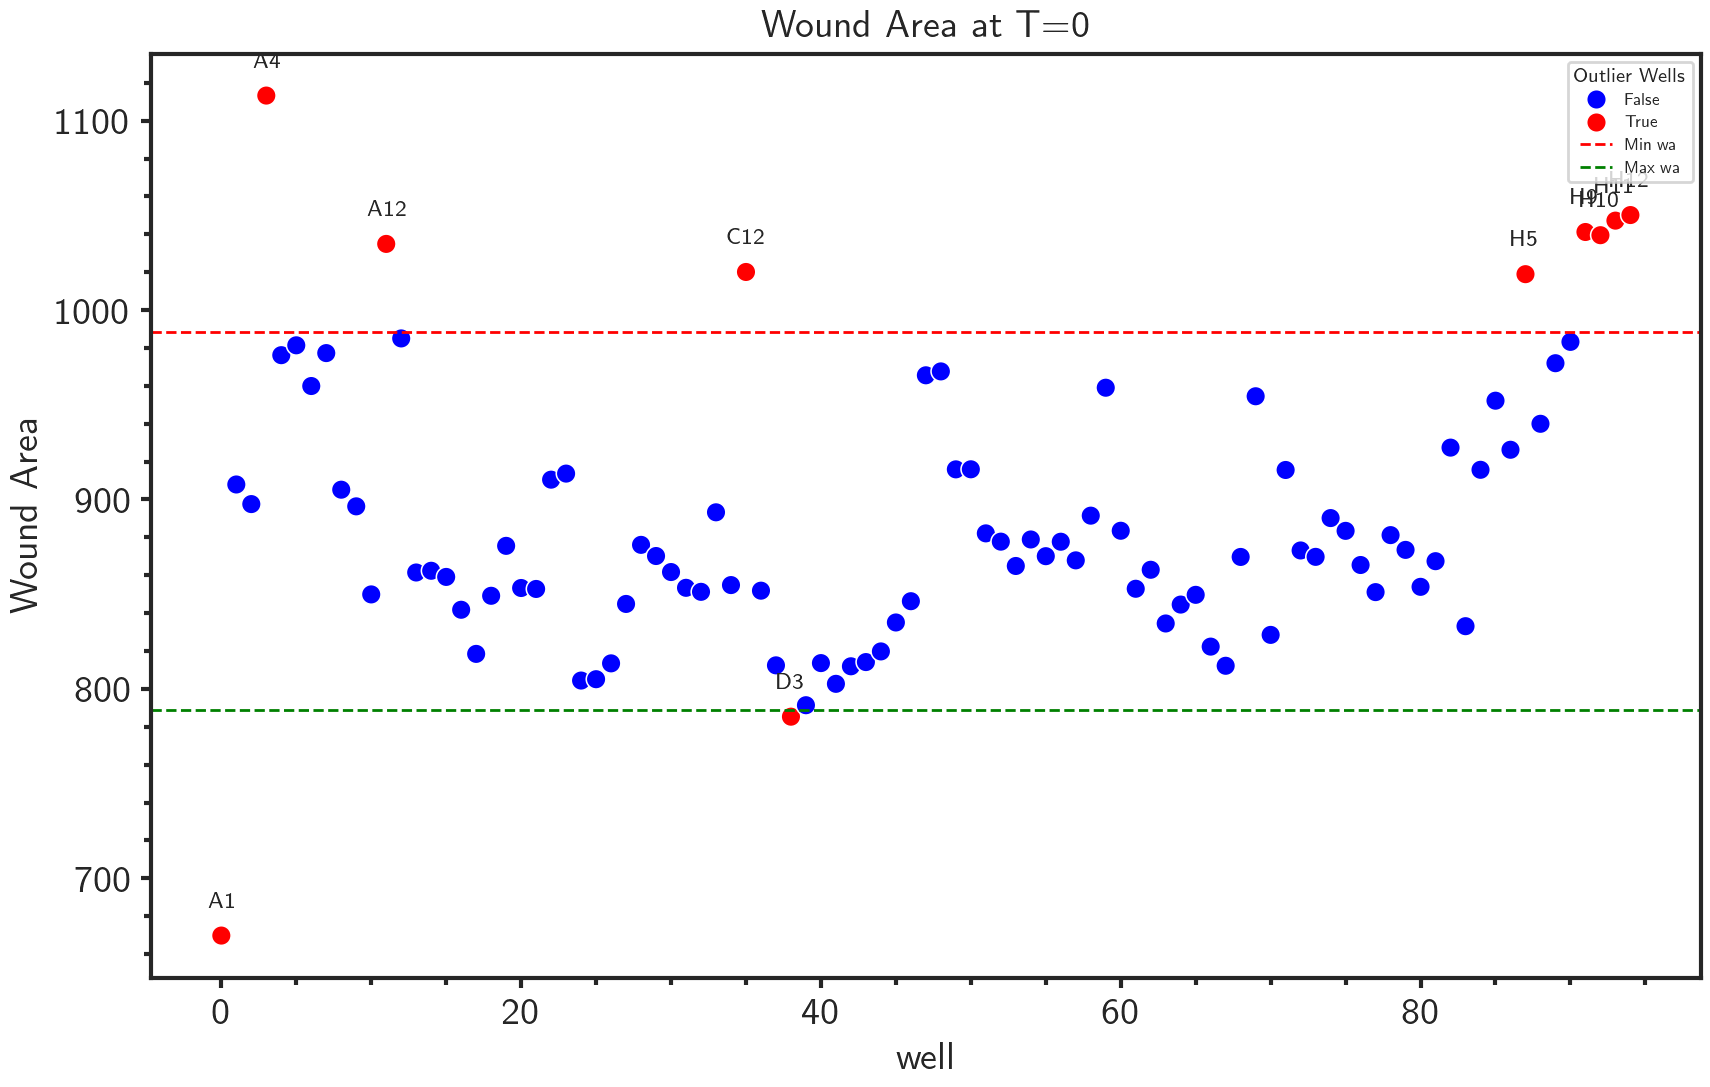

Finished processing SWP5.xls.
Processing SWP6.xls...
Processing file: Z:\Anish\Code Analyzed Data\20250706\SW\SWP6.xls
Dropping columns: ['A12' 'B12' 'C12' 'D12' 'F9' 'F12' 'H12'] from SWP6
Wells outside bounds for SWP6: 
['B8', 'C3', 'E5', 'E9', 'E10', 'F10']


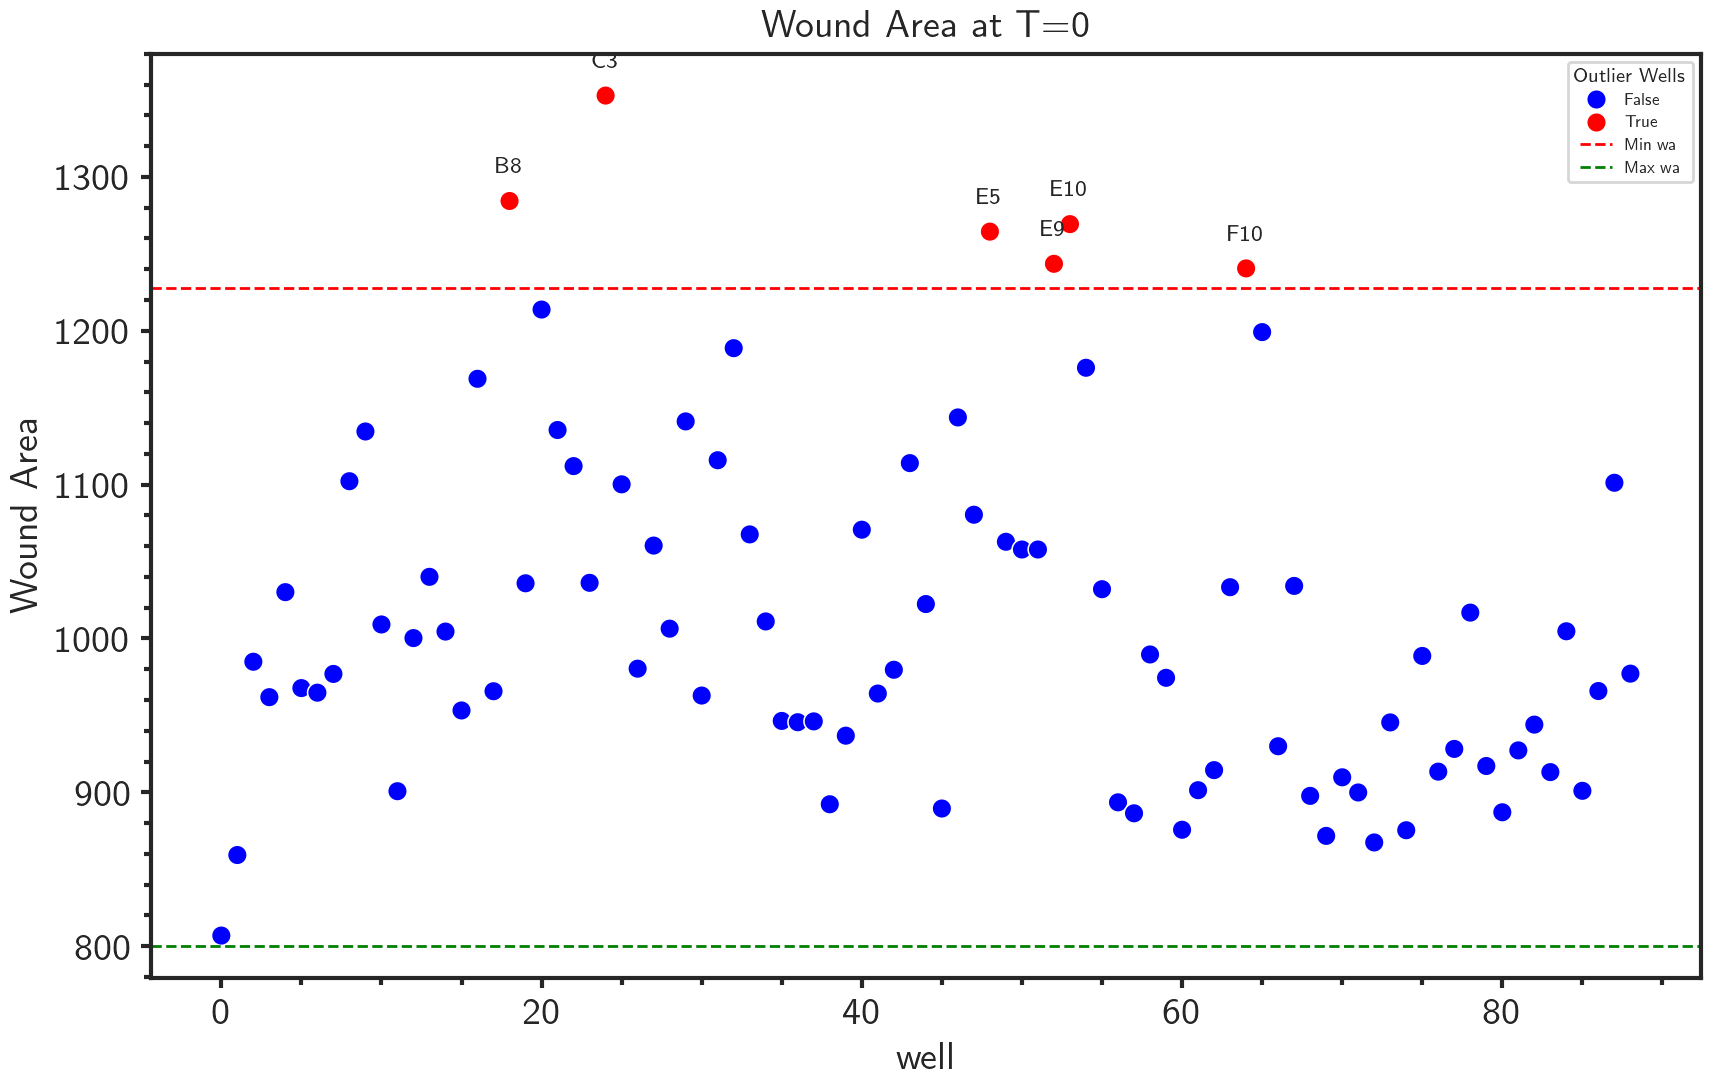

Finished processing SWP6.xls.


In [41]:
# Create full file paths
file_paths = [os.path.join(dir_parent, file_name) for file_name in file_names]
print("Filenames to process:", file_names)

#Store extracted data in a dictionary addressable by file_name in file_names
extracted_data = {}
for file_name, file_path in zip(file_names, file_paths):
    print(f"Processing {file_name}...")
    extracted_data[file_name.split('.')[0]] = process_excel_files(file_name.split('.')[0],file_path)
    print(f"Finished processing {file_name}.")

# Extract cell type information for each filename
cell_type = pd.read_excel(os.path.join(dir_parent, 'cell_type_log.xlsx'), sheet_name='Sheet1')

Plotting outlier wells for SWP5: ['A1', 'A4', 'A12', 'C12', 'D3', 'H5', 'H9', 'H10', 'H11', 'H12']


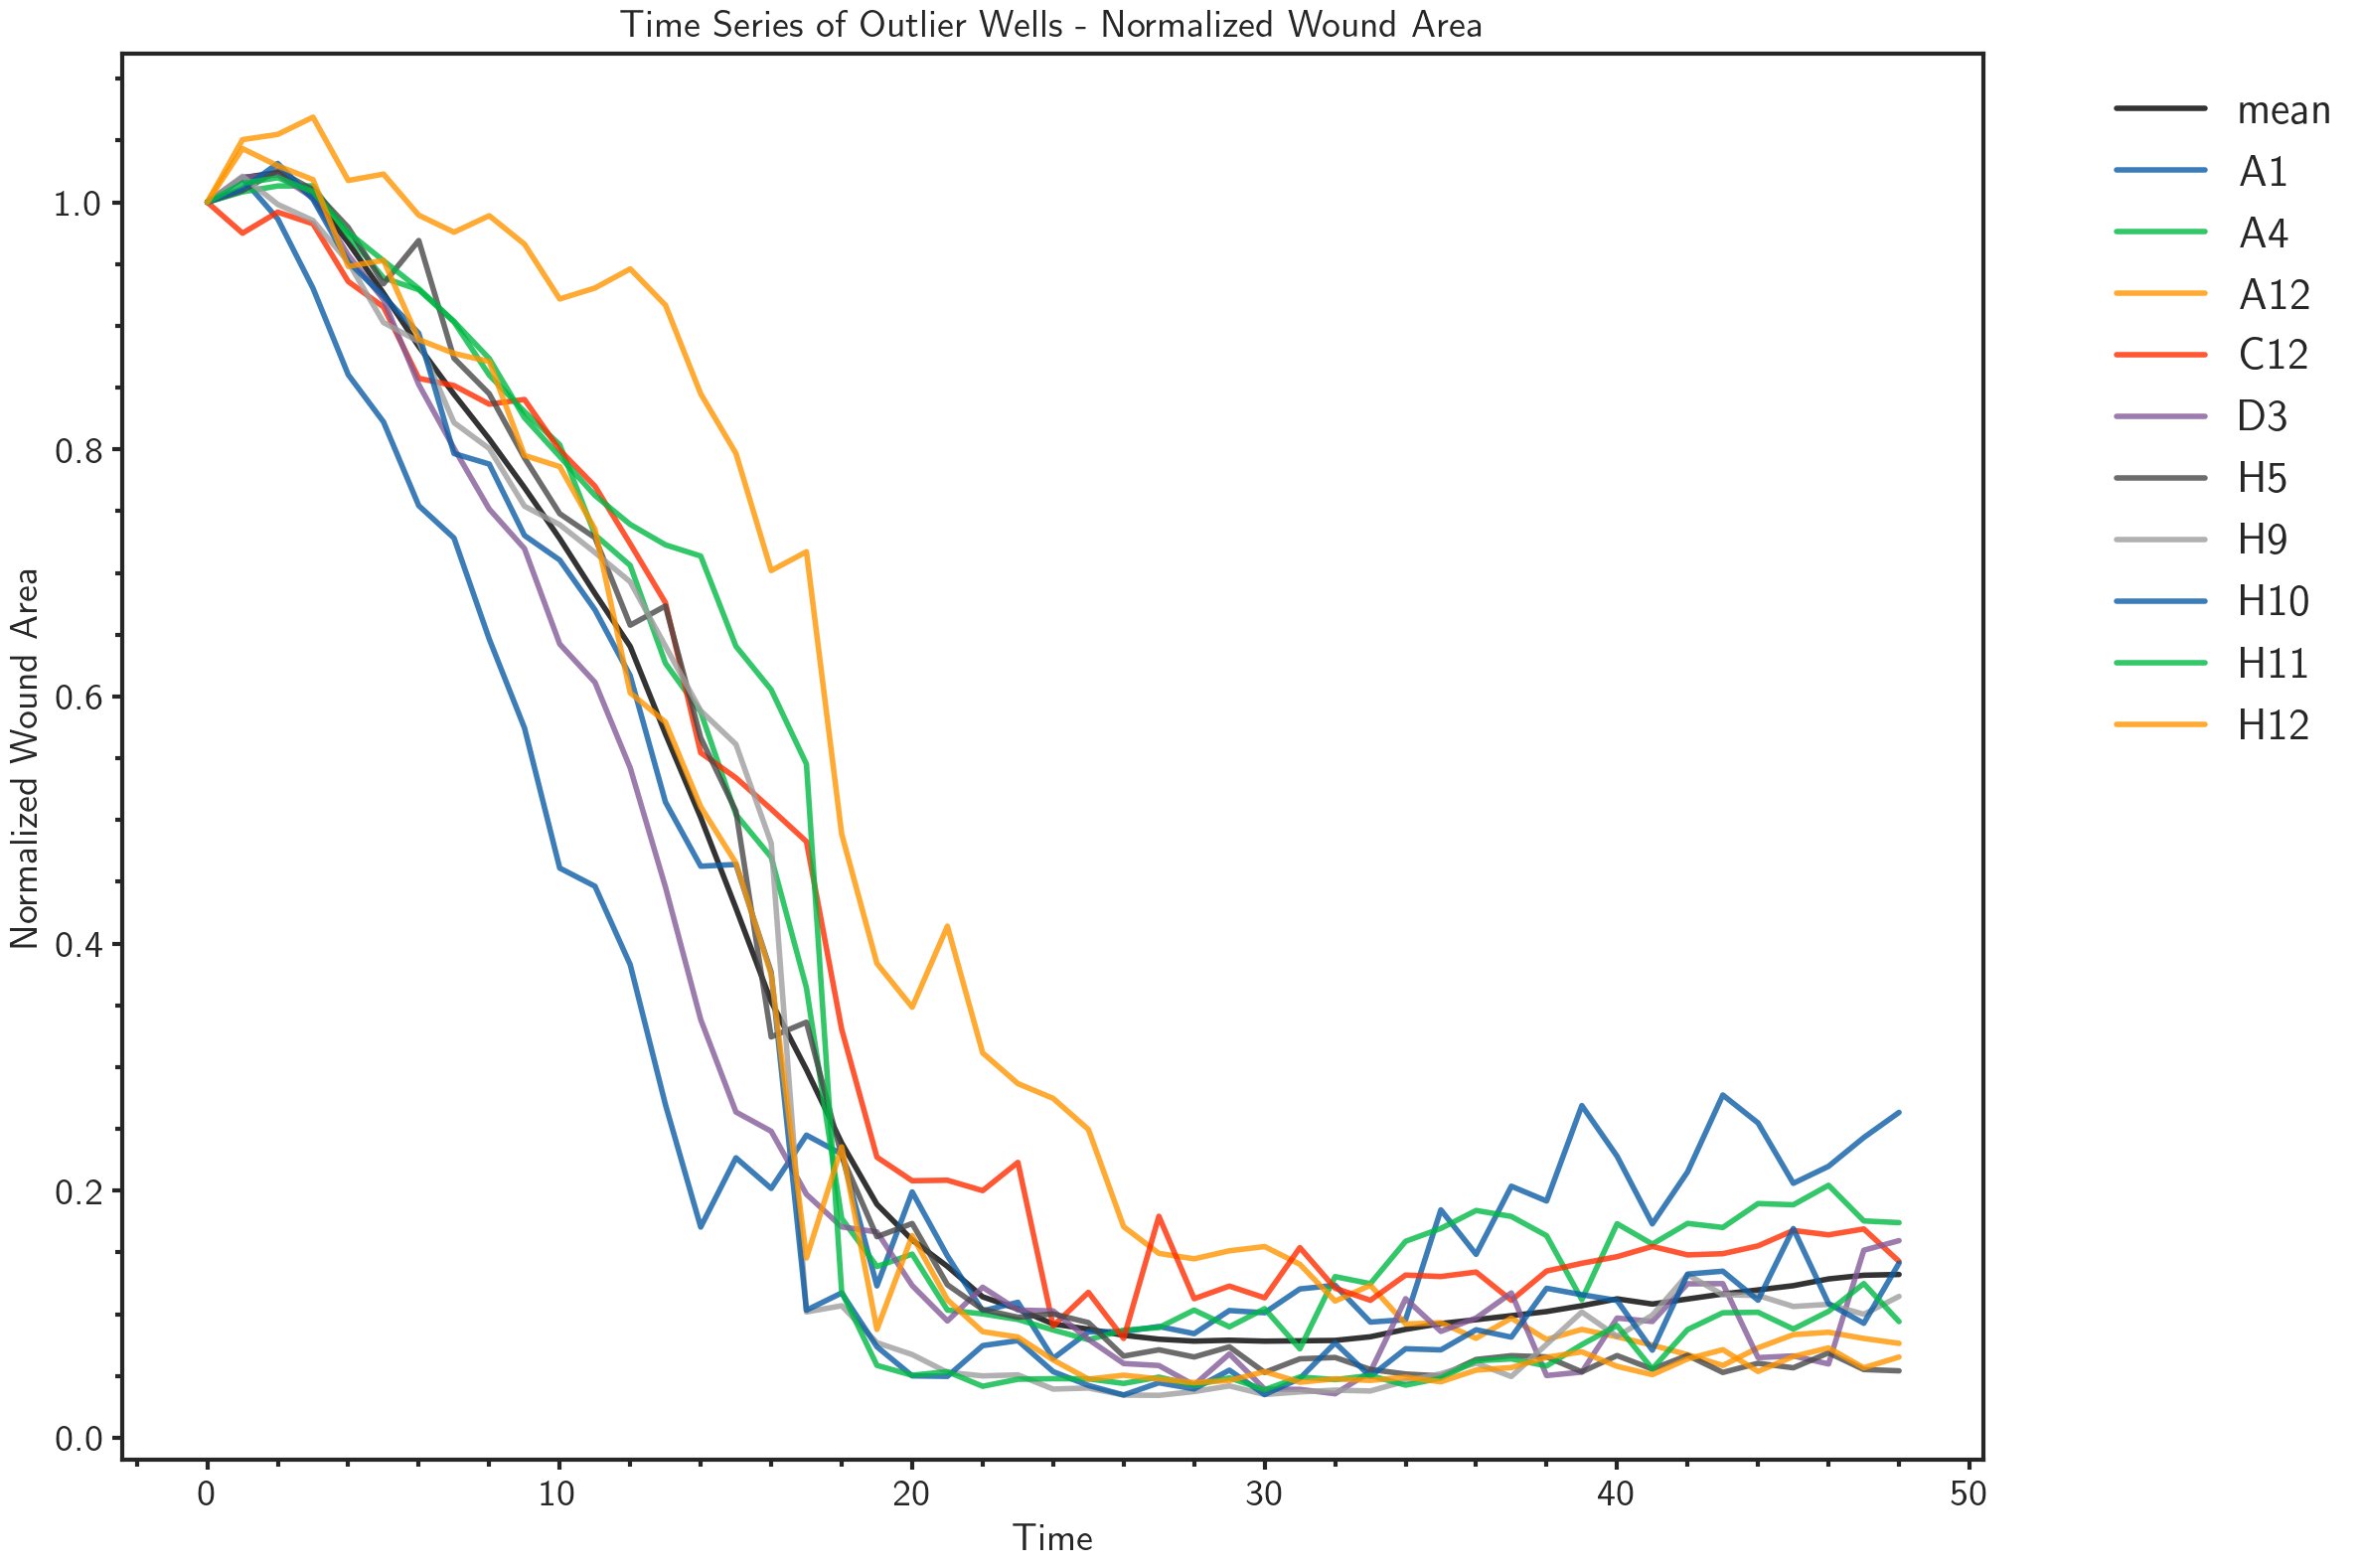

Plotting outlier wells for SWP6: ['B8', 'C3', 'E5', 'E9', 'E10', 'F10']


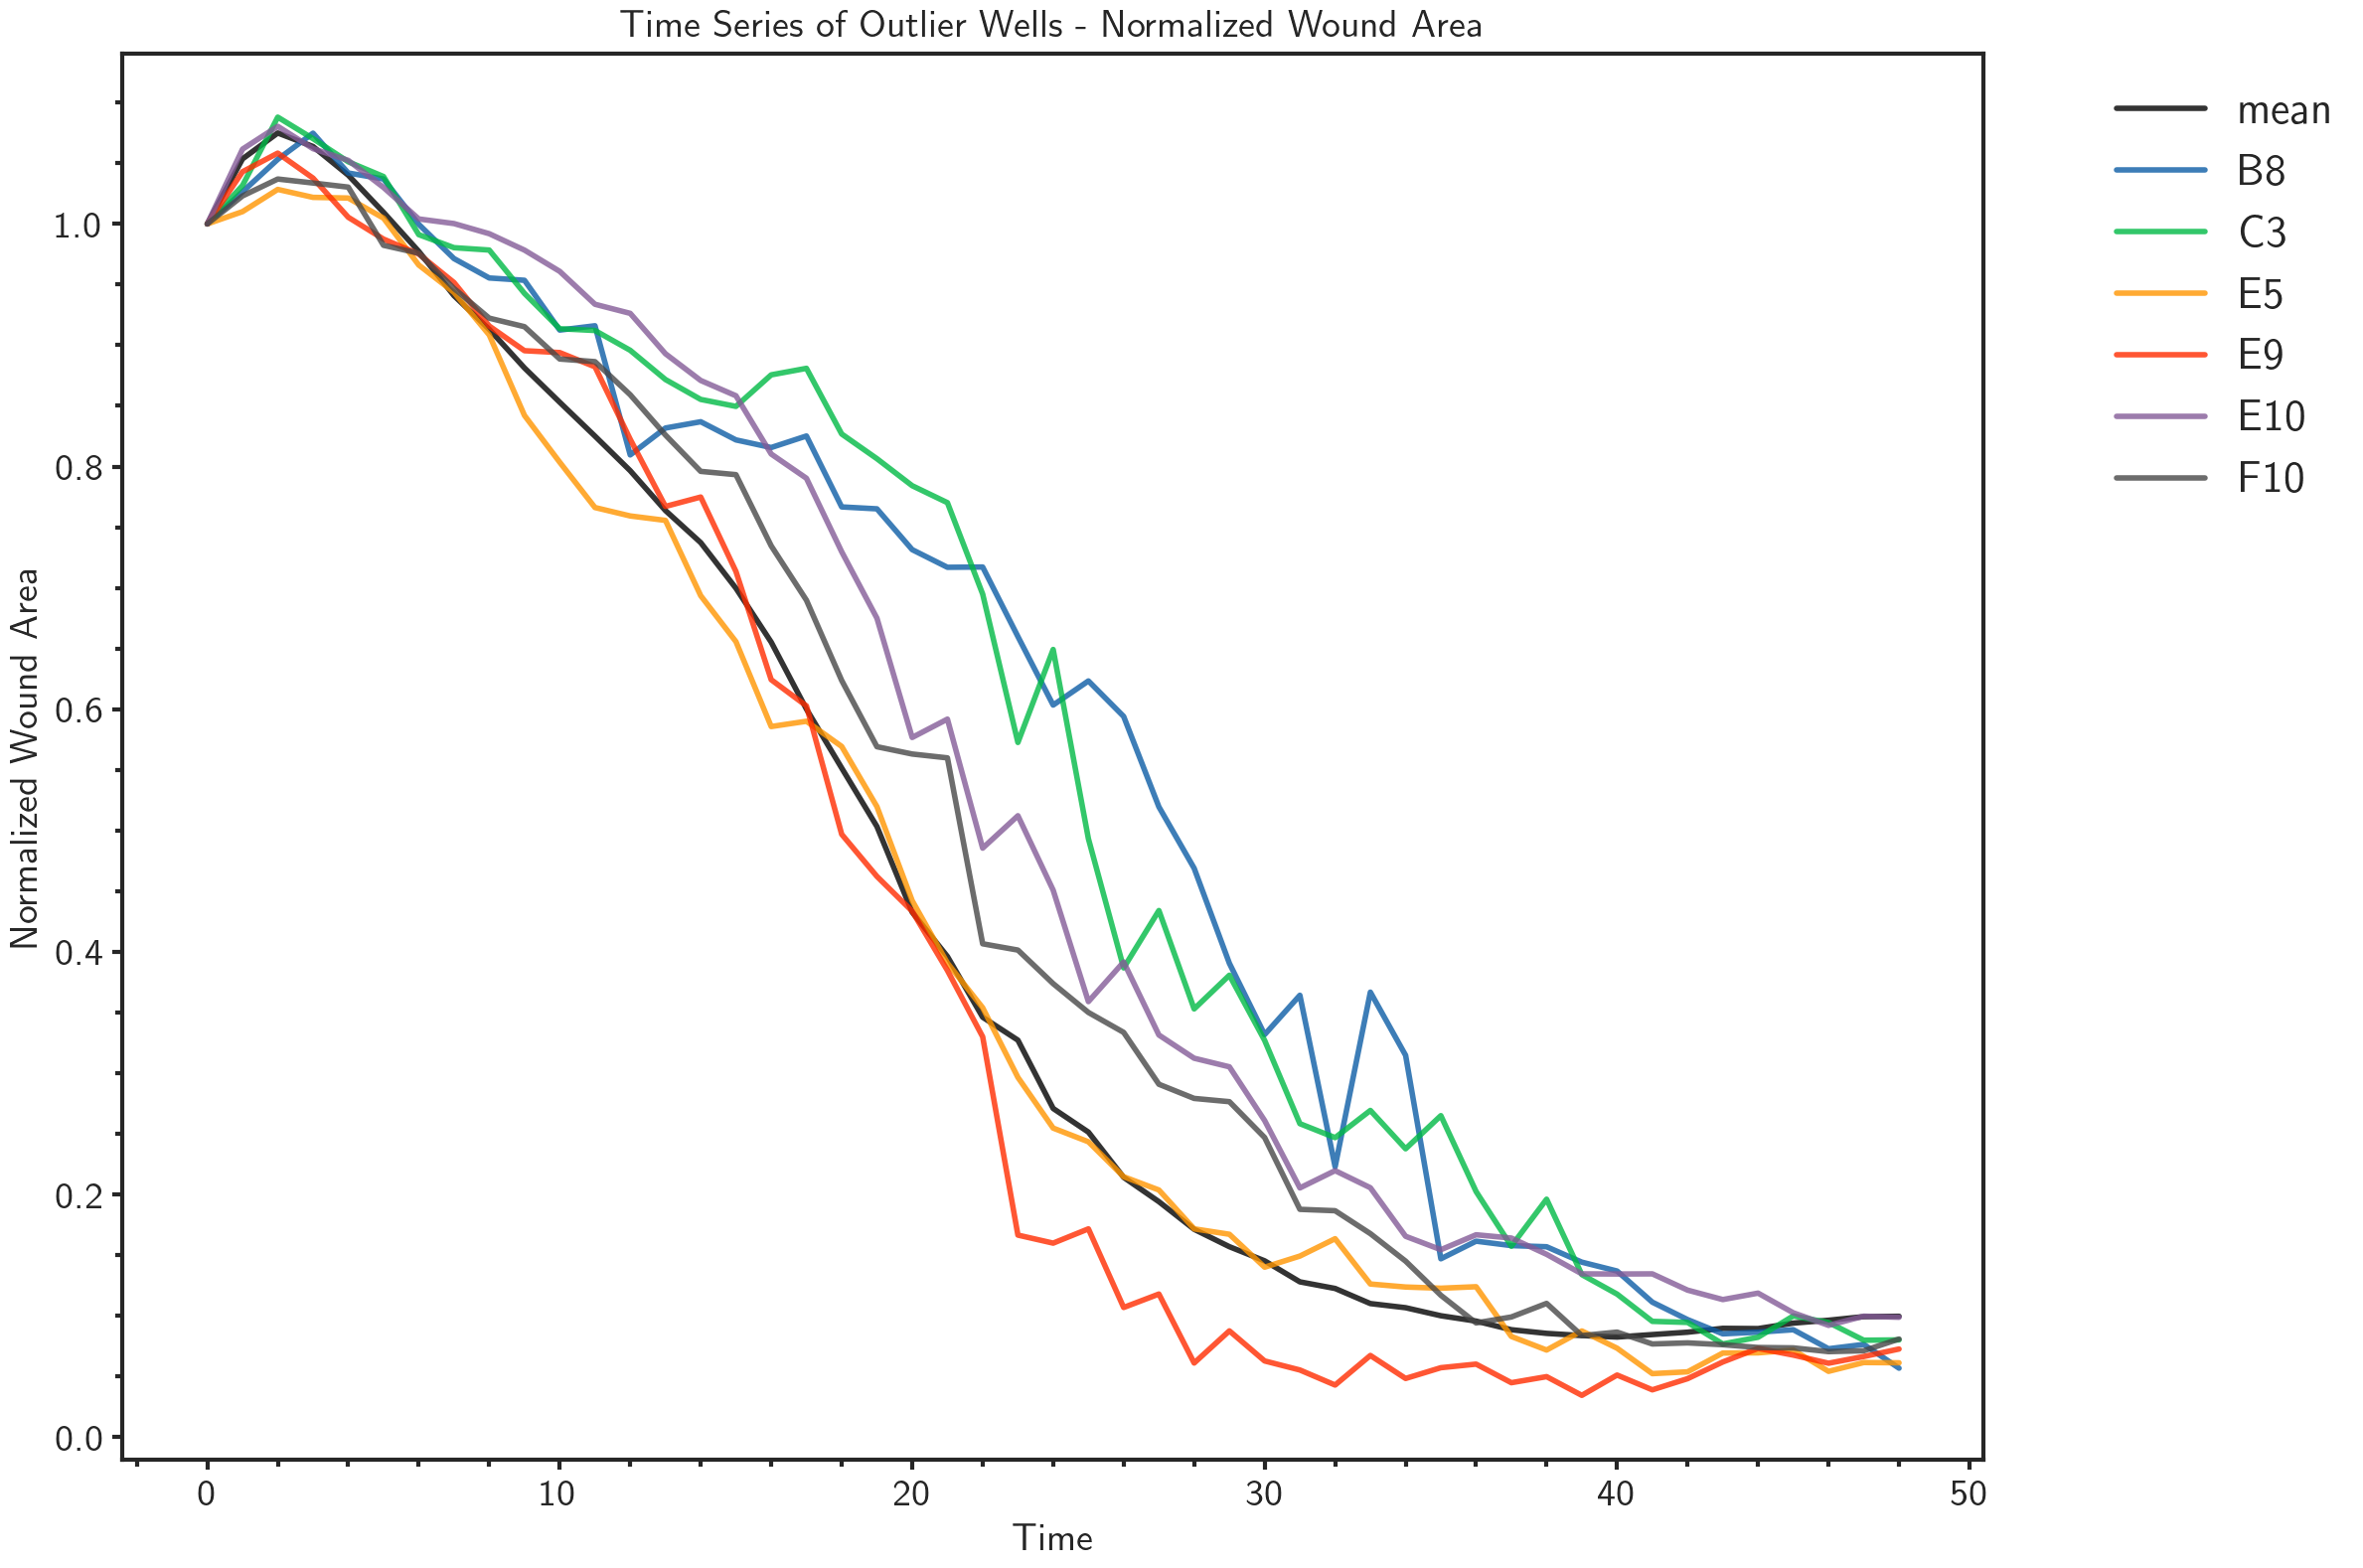

In [42]:
# Plot outlier wells wound area vs time

for file_name, data in extracted_data.items():
    if data['outlier_wells']:
        plot_outlier_wound_areas(data['outlier_wells'], data['wound_area_normalized'], data['time_index'], file_name)

### Drop outliers

In [43]:
# extracted_data = drop_outliers(extracted_data)

### Reshape Data to human readable format and long format for plotting


In [44]:
# Make a combined dataset of all the conditions in the extracted_data dictionary.
dict_combined_conditions, combined_conditions_counts = combine_conditions(extracted_data)

#### Drop Unnecessary Conditions

In [45]:
#Drop unnecessary conditions
conditions_to_drop = ['bad device', 'seeding problem', 'Ctrl', 'Diclofenac_10 uM','Ibuprofen Lysine_10 uM','PDGF-BB_Old', 'Nintedanib_10uM', ]

for condition in conditions_to_drop:
    # Use exact case-insensitive matching
    keys_to_remove = [key for key in dict_combined_conditions.keys() if key.lower() == condition.lower()]

    if keys_to_remove:
        for key_to_remove in keys_to_remove:
            print(f"Removing '{key_to_remove}' condition from combined conditions and extracted data...")
            del dict_combined_conditions[key_to_remove]
            for experiment in extracted_data.keys():
                if key_to_remove in extracted_data[experiment]['dict_condition'].keys():
                    del extracted_data[experiment]['dict_condition'][key_to_remove]
            combined_conditions_counts = combined_conditions_counts.drop(key_to_remove, axis=0)

#### Long Format for Plotting

In [46]:
# Find the shortest time index in the extracted_data dictionary
# This is to ensure that the reshaped data has the same time index as the original data
# Return the key with the shortest time index
shortest_time_index = min(extracted_data.keys(), key=lambda k: len(extracted_data[k]['time_index']))
# Reshape the combined condition dictionary
reshaped_data = reshape_combined_conditions(extracted_data, extracted_data[shortest_time_index]['time_index'],cell_type)

### Plot Time Series Data

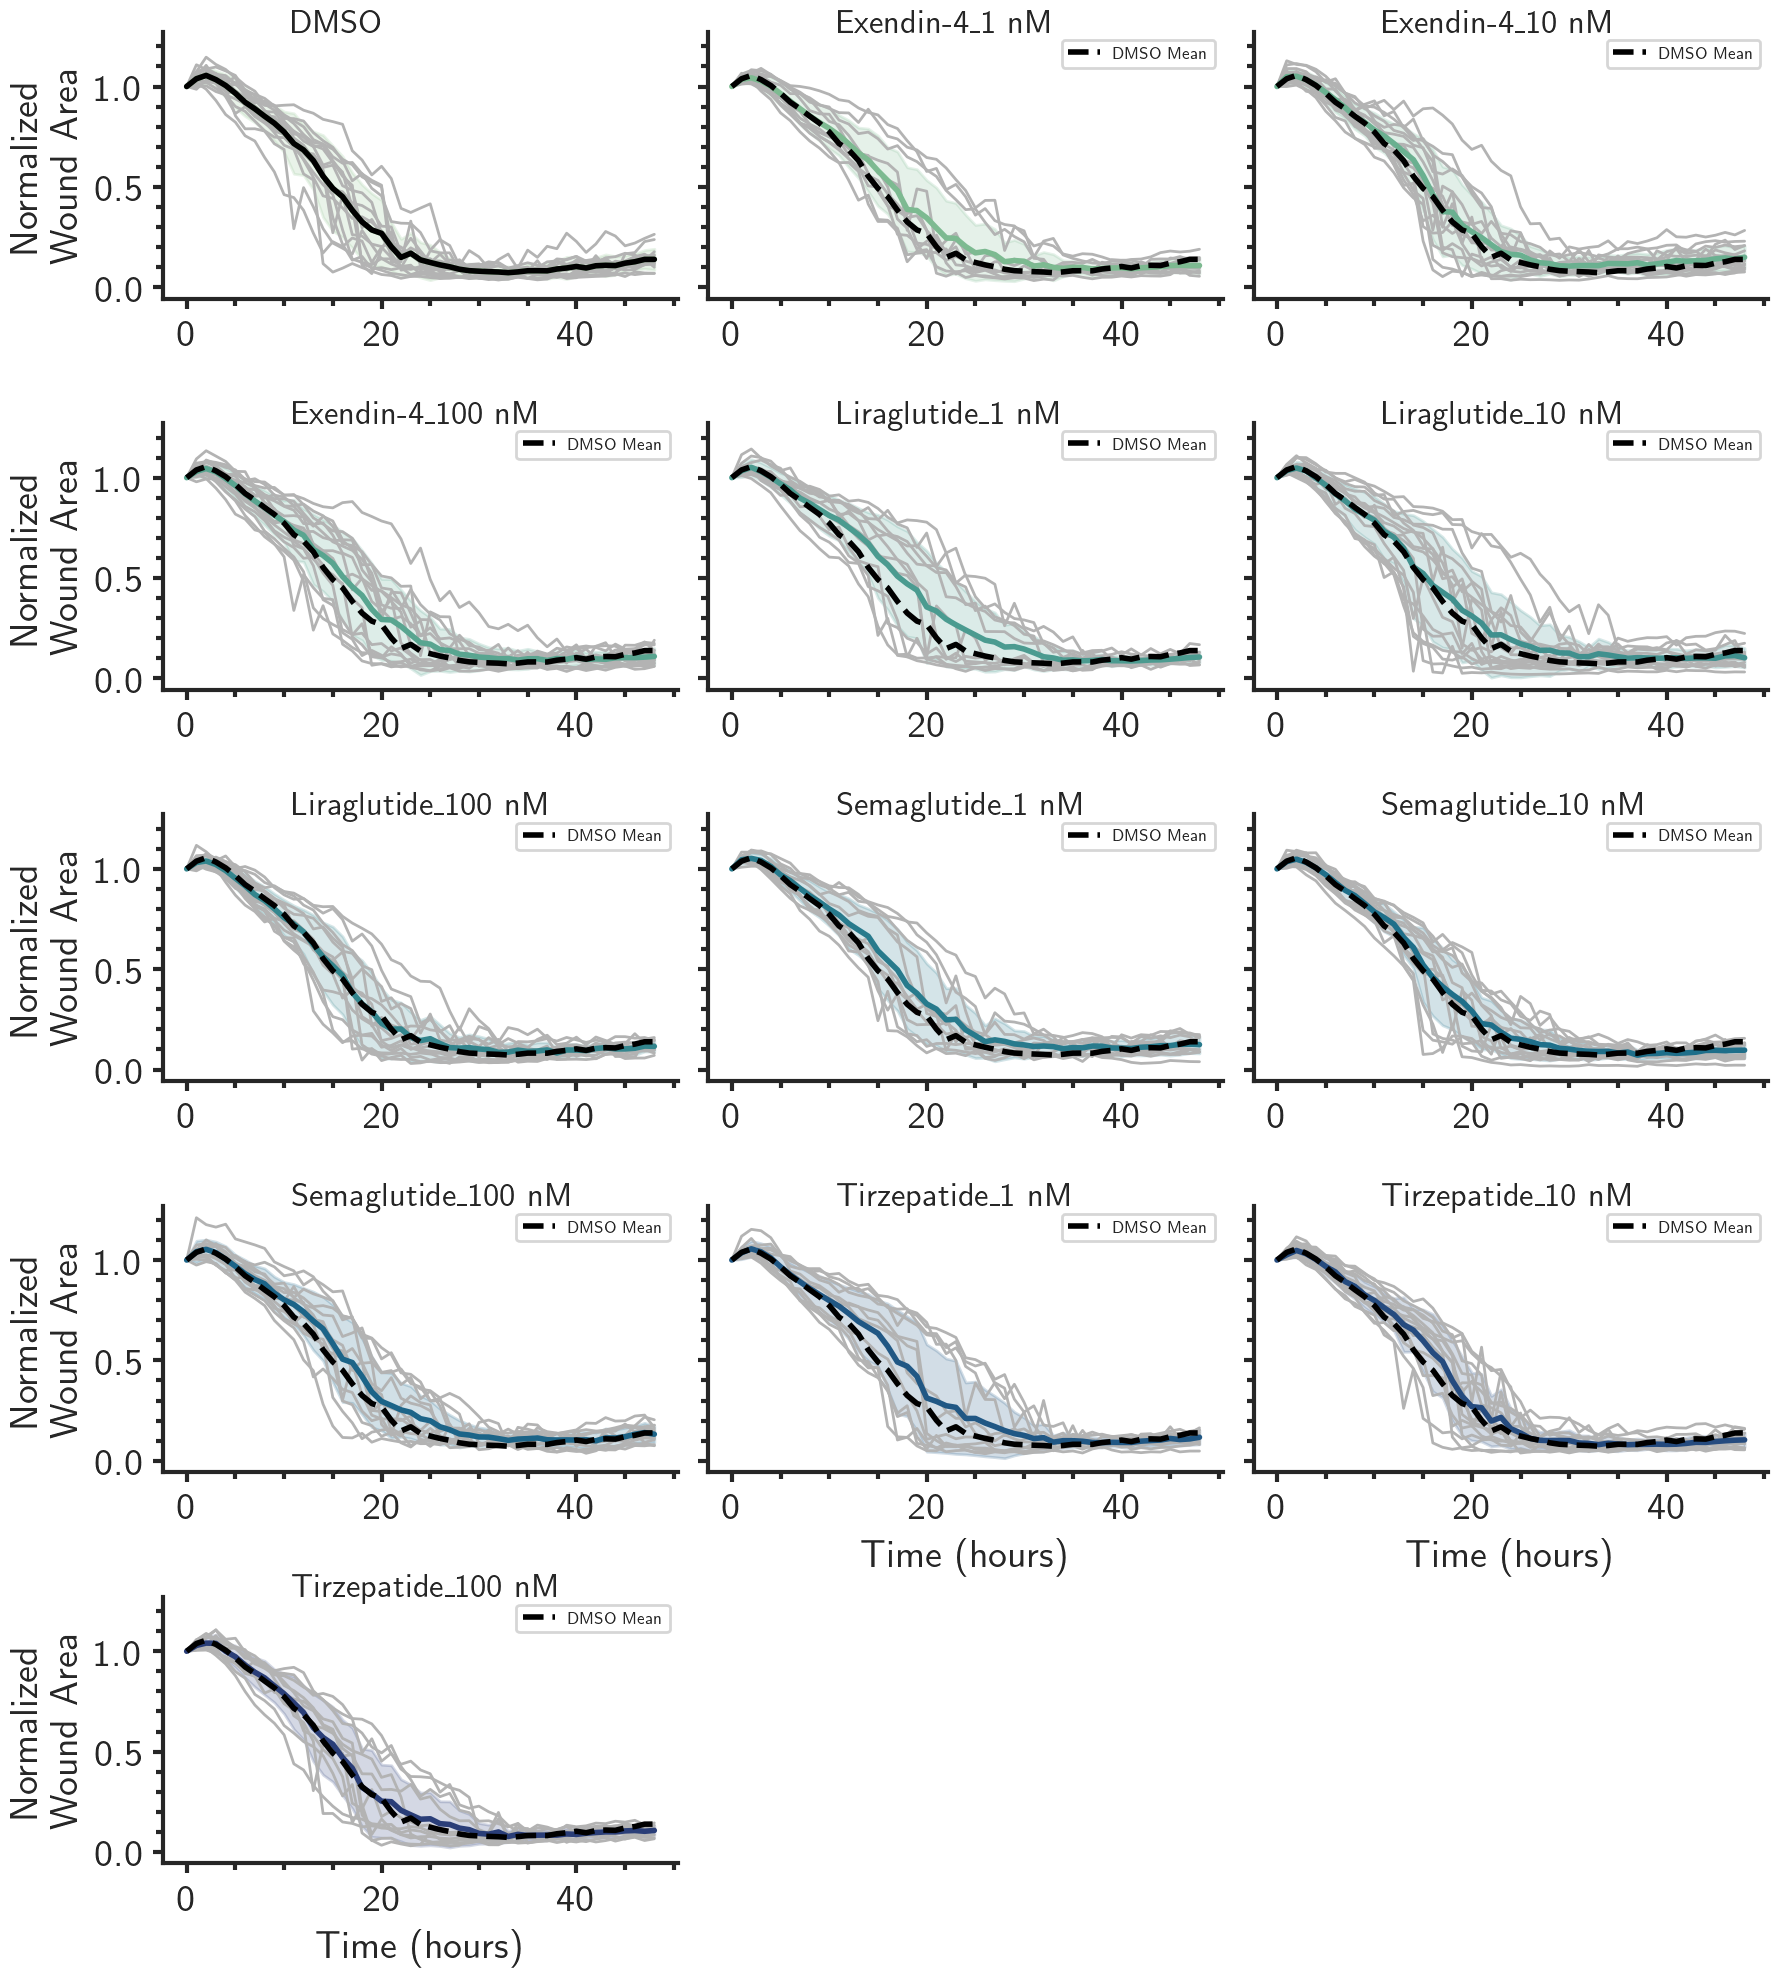

In [47]:
# Plotting the time series data using seaborn
# Plot average time series with individual wells in lighter color
# Sort the data into alphabetical order for plotting. Put DMSO and PDGF-BB as the first two conditions followed by the others in alphabetical order.
# Define priority controls
first = 'DMSO'
second = 'PDGF-BB_100 ng/mL'

# All unique conditions
all_conditions = sorted(dict_combined_conditions.keys())

# Keep only existing controls (in case PDGF-BB absent)
present_controls = [c for c in [first, second] if c in all_conditions]

# Remaining (exclude controls), sorted
remaining = sorted([c for c in all_conditions if c not in present_controls])

# Final ordered list
ordered_conditions = present_controls + remaining


g = sns.relplot(
    data=reshaped_data,
    x="time_index", y="wound_area_normalized", col="condition_map", hue="condition_map",
    kind="line", palette="crest", linewidth=2, zorder=5,
    col_wrap=3, height=2, aspect=1.5, legend=False,errorbar = "sd", col_order=ordered_conditions,
    hue_order=ordered_conditions,
    facet_kws={'sharex': False, 'sharey': True}
)

# Calculate the mean wound area for the control group to plot as a reference line
mean_control_group = reshaped_data[reshaped_data['condition_map'] == control_group_name].groupby('time_index')['wound_area_normalized'].mean().reset_index()

# Iterate over each subplot to customize further
for condition, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(0.25, 1, condition, transform=ax.transAxes, fontweight="bold", fontsize=12)

    # Filter data for only the current condition
    condition_data = reshaped_data[reshaped_data['condition_map'] == condition]
    # Plot every condition's time series in the background. Color code them according to the experiment they belong to (exp)
    # sns.lineplot( data=condition_data, x='time_index', y='wound_area', units='exp', alpha=0.5, legend=False, ax=ax, zorder=1)

    sns.lineplot(
        data=condition_data, x='time_index', y='wound_area_normalized', units='well', estimator=None, color='0.7', legend=False, ax=ax, zorder=1
    )

    # Plot DMSO mean line (skip if current condition is DMSO itself)
    if condition != 'DMSO':
        #print('Plotting DMSO mean line for condition:', condition)
        ax.plot(mean_control_group['time_index'], mean_control_group['wound_area_normalized'], color='black', linewidth=2, linestyle='--', alpha=1, label='DMSO Mean',zorder=20)
        # Add a legend for the DMSO mean line
        ax.legend(loc='upper right', fontsize='small',
                  title_fontsize='medium', frameon=True, shadow=False, fancybox=True)
    else:
        # If the condition is DMSO, just add a label to the mean line
        ax.plot(mean_control_group['time_index'], mean_control_group['wound_area_normalized'], color='black', linewidth=2, linestyle='-', alpha=1, label='Mean', zorder=20)

# Set labels and layout
g.set_titles("")
g.set_axis_labels("Time (hours)", "Normalized \n Wound Area")

plt.savefig('average_plot_with_std_seaborn.svg', dpi=600)
g.tight_layout()
plt.show()

### Help

In [48]:


import pandas as pd
import numpy as np
from scipy.integrate import trapezoid
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullLocator

# --- Configuration ---
alpha = 0.05
response_col = 'wound_area_normalized'
time_col = 'time_index'
group_col = 'condition_map'
id_cols = ['well', group_col, 'exp']

# --- 1. Compute AUC per well ---
def compute_auc(g: pd.DataFrame) -> pd.Series:
    g = g.sort_values(time_col)
    val = trapezoid(g[response_col].to_numpy(), g[time_col].to_numpy())
    return pd.Series({'auc': val})

auc_data = (
    reshaped_data
    .groupby(id_cols, as_index=False)
    .apply(compute_auc)
)

auc_data['auc']=auc_data['auc']*(0.889*0.889)


C:\Users\anish\AppData\Local\Temp\ipykernel_33460\2358889427.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(compute_auc)


In [49]:

# Rename columns for convenience
auc_data.columns = ['SampleID', 'Condition', 'SampleGroup', 'AUC']

Kruskal-Wallis H-statistic: 6.7934, p-value: 0.8710
DMSO: a
Exendin-4_1 nM: a
Exendin-4_10 nM: a
Exendin-4_100 nM: a
Liraglutide_1 nM: a
Liraglutide_10 nM: a
Liraglutide_100 nM: a
Semaglutide_1 nM: a
Semaglutide_10 nM: a
Semaglutide_100 nM: a
Tirzepatide_1 nM: a
Tirzepatide_10 nM: a
Tirzepatide_100 nM: a


C:\Users\anish\AppData\Local\Temp\ipykernel_33460\1351005283.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sig_matrix = sig_matrix.applymap(lambda p: p < alpha if not np.isnan(p) else False)
C:\Users\anish\AppData\Local\Temp\ipykernel_33460\1351005283.py:137: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Condition', y='AUC', data=auc_data, palette=palette, order=ordered_conditions, fliersize=10)
C:\Users\anish\AppData\Local\Temp\ipykernel_33460\1351005283.py:138: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(x='Condition', y='AUC', data=auc_data, color='black', edgecolor='gray', size=5, order=ordered_conditions)


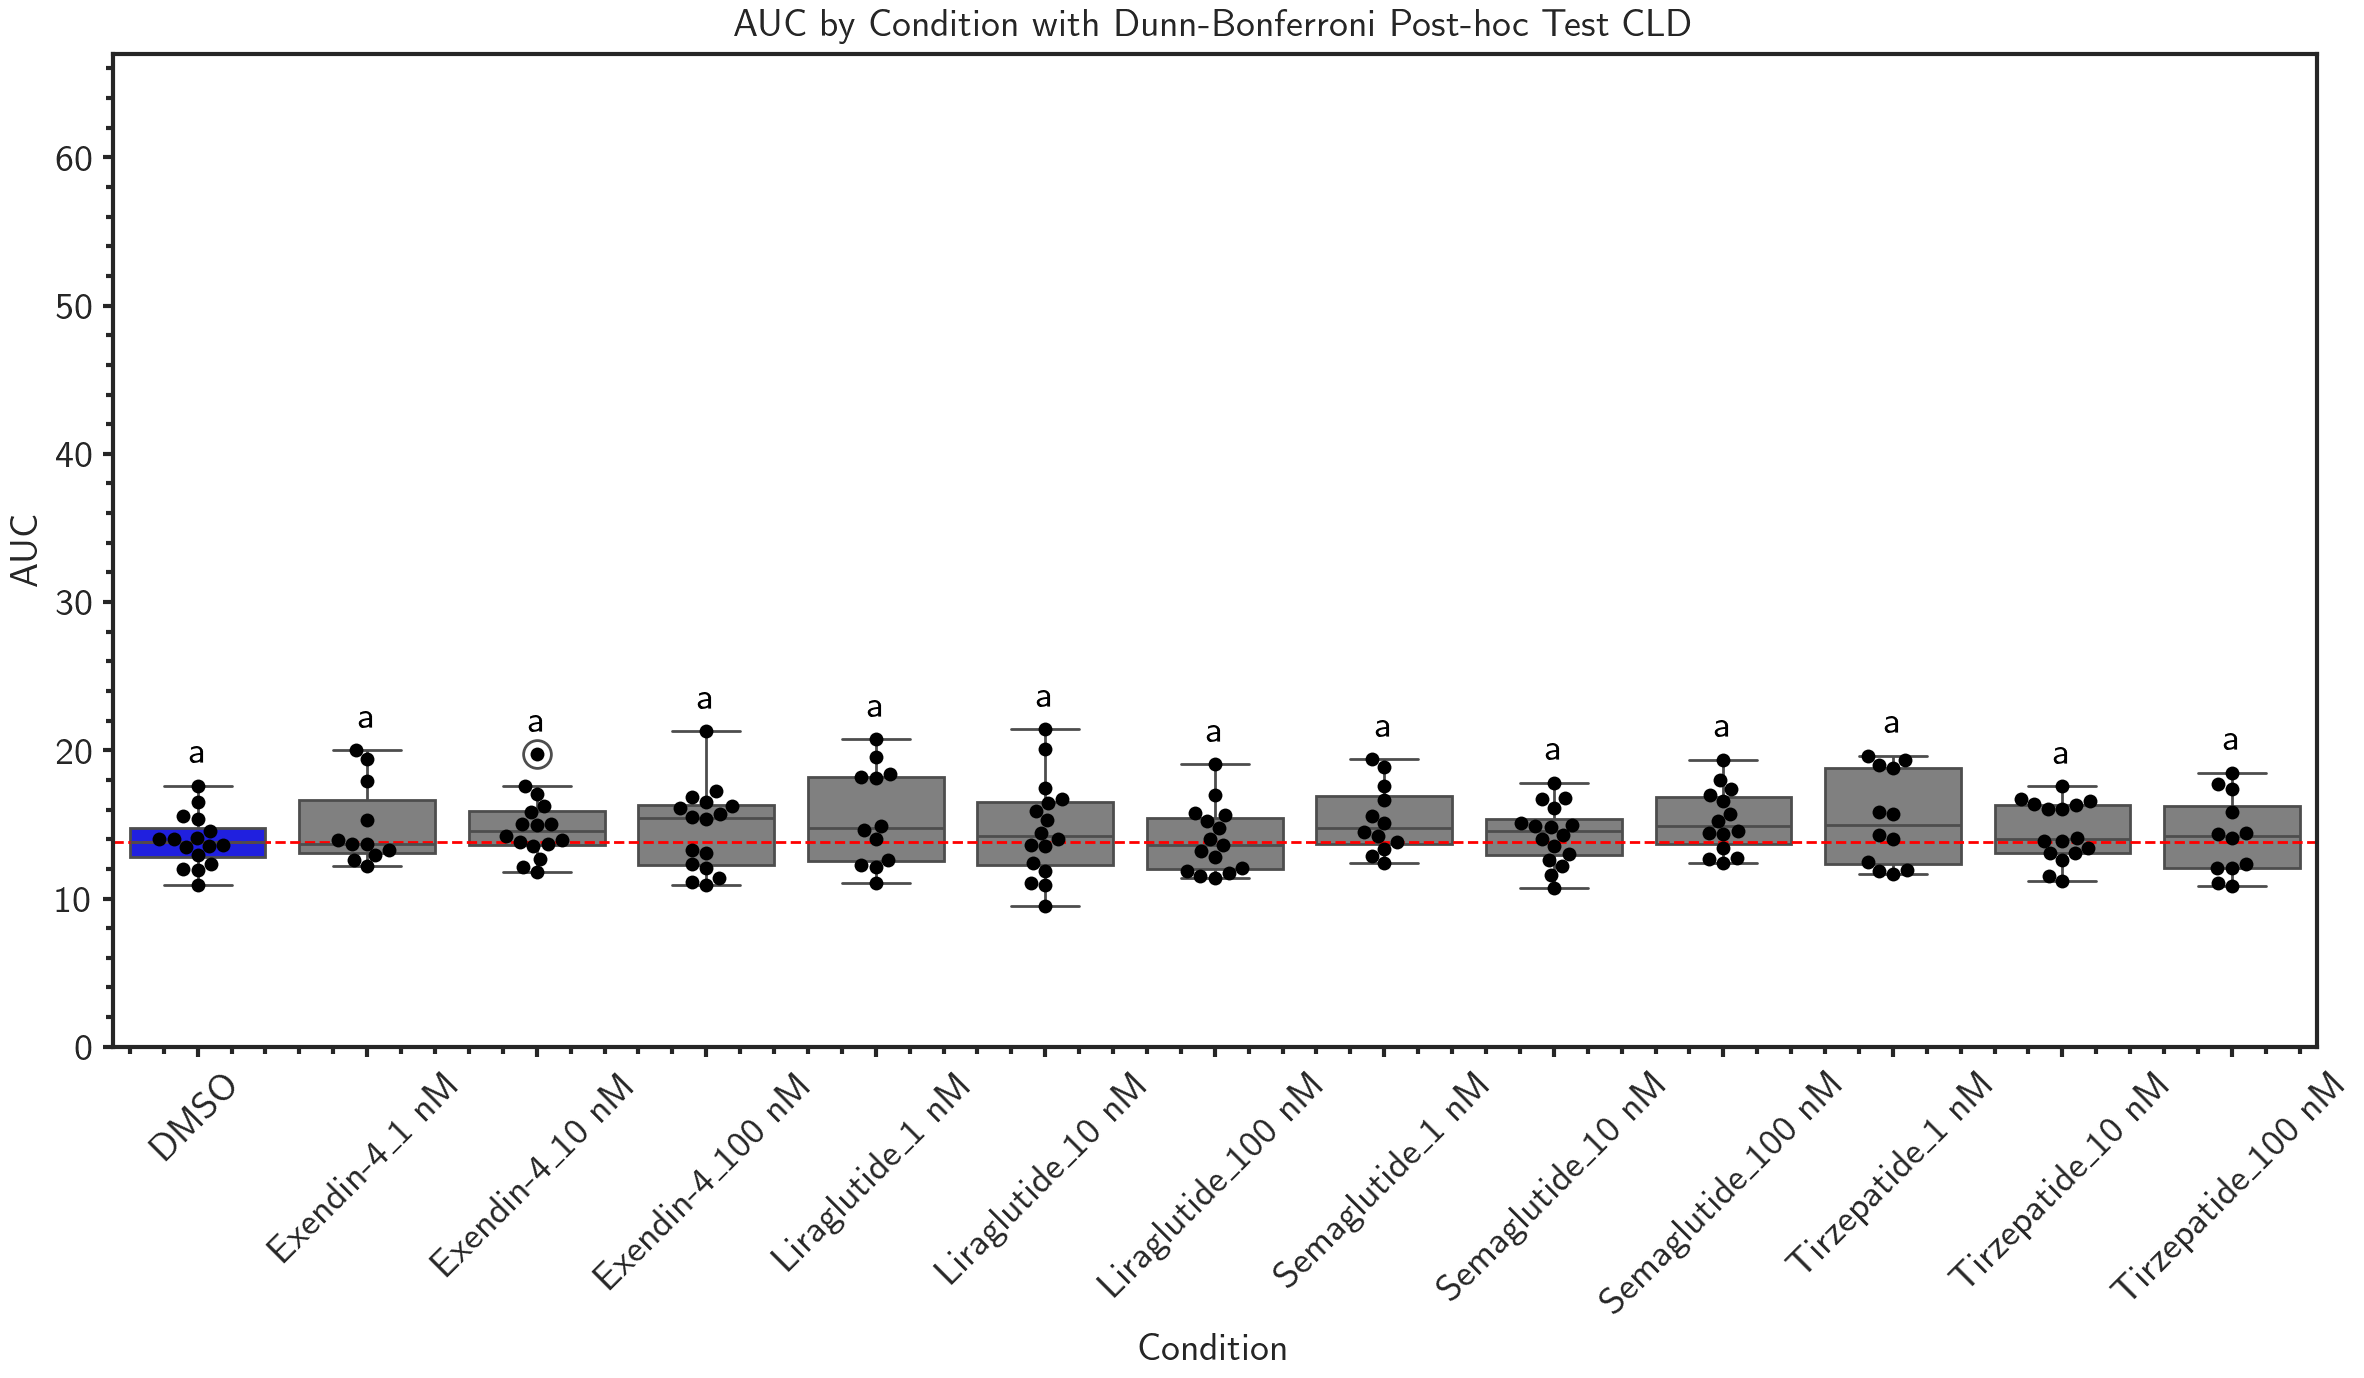

In [50]:
# --- Configuration ---
alpha = 0.05
response_col = 'wound_area_normalized'
time_col = 'time_index'
group_col = 'condition_map'
id_cols = ['well', group_col, 'exp']



import pandas as pd
import numpy as np
import scipy.stats as stats
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests
import string
import networkx as nx
# Load data


# Kruskal-Wallis Test across groups
groups = auc_data['Condition'].unique()
data_groups = [auc_data.loc[auc_data['Condition'] == g, 'AUC'].values for g in groups]
h_stat, p_kw = stats.kruskal(*data_groups)
print(f"Kruskal-Wallis H-statistic: {h_stat:.4f}, p-value: {p_kw:.4f}")

# Post-hoc Dunn test vs control (DMSO) with Bonferroni correction
control = 'DMSO'
# Dunn's test from scikit-posthocs offers pairwise p-values for all groups; we extract pairwise vs control
dunn_res = sp.posthoc_dunn(auc_data, val_col='AUC', group_col='Condition', p_adjust='bonferroni')

# Extract p-values comparing each group vs control
p_values_vs_control = dunn_res.loc[control].drop(control)

# Determine significance and direction
group_means = auc_data.groupby('Condition')['AUC'].mean()
significance = {}
alpha = 0.05
for g, pval in p_values_vs_control.items():
    if pval < alpha:
        # Determine if larger or smaller than control mean
        if group_means[g] > group_means[control]:
            significance[g] = 'larger'
        else:
            significance[g] = 'smaller'
    else:
        significance[g] = 'ns'  # not significant

# Add control group status
significance[control] = 'control'

# Ensure all conditions have a significance entry (if missing, assign 'ns')
unique_conditions = auc_data['Condition'].unique()
for cond in unique_conditions:
    if cond not in significance:
        significance[cond] = 'ns'

# Define color mapping for significance categories
palette_map = {
    'control': 'blue',
    'larger': 'red',
    'smaller': 'green',
    'ns': 'grey'
}

# Build full palette dictionary for all conditions based on significance
palette = {cond: palette_map[significance[cond]] for cond in unique_conditions}

# Map colors to DataFrame for plotting
auc_data['Color'] = auc_data['Condition'].map(palette)

# Prepare compact letter display (CLD) - assign letters so groups with no significant difference share letters
# We'll create pairwise significance matrix to generate CLD
# Make a boolean matrix for significant differences (True = significantly different)
sig_matrix = dunn_res.copy()
sig_matrix = sig_matrix.applymap(lambda p: p < alpha if not np.isnan(p) else False)

# For CLD, groups not significantly different share letter; we'll invert significance to non-significance matrix
nsgn_matrix = ~sig_matrix

# CLD function


def multi_letter_cld_graph(no_sig_matrix):
    """
    Generate multi-letter CLD using maximal cliques in the no-significance graph.
    no_sig_matrix: pd.DataFrame, symmetric boolean matrix (True=no significant difference)
    Returns: dict mapping group->multi-letter string (e.g., 'ab', 'c', etc.)
    """
    groups = no_sig_matrix.index.tolist()
    # Build graph where an edge exists if two groups are NOT significantly different (True)
    G = nx.Graph()

    # Add nodes
    G.add_nodes_from(groups)

    # Add edges for True in no_sig_matrix excluding self-loops
    for i, g1 in enumerate(groups):
        for j, g2 in enumerate(groups):
            if i < j and no_sig_matrix.loc[g1, g2]:
                G.add_edge(g1, g2)

    # Find maximal cliques (complete subgraphs)
    cliques = list(nx.find_cliques(G))

    # Assign letters to cliques
    letters = list(string.ascii_lowercase)
    letter_cliques = {letters[i]: cliques[i] for i in range(len(cliques)) if i < len(letters)}

    # Assign letters to groups: each group collects letters for cliques it belongs to
    cld_map = {g: '' for g in groups}
    for letter, clique in letter_cliques.items():
        for g in clique:
            cld_map[g] += letter

    # Sort letters in each string for readability
    for g in cld_map:
        cld_map[g] = ''.join(sorted(cld_map[g]))

    return cld_map

cld_multi = multi_letter_cld_graph(nsgn_matrix)
# To see assigned multi-letter CLD per group
for group, letters in cld_multi.items():
    print(f"{group}: {letters}")
# Add CLD to dataframe for plotting labels
cld_df = pd.DataFrame({
    'Condition': ordered_conditions,
    'CLD': [cld_multi[g] for g in ordered_conditions]
})
# cld_multi = pd.read_excel('D:\\OneDrive\\Boston University\\OneDrive - Boston University\\Desktop\\CLD.xlsx', sheet_name='Sheet1')
# cld_multi = dict(zip(cld_multi['Condition'], cld_multi['CLD']))

# Plot boxplot + swarmplot with colors coded by significance
plt.figure(figsize=(12, 7))
ax = sns.boxplot(x='Condition', y='AUC', data=auc_data, palette=palette, order=ordered_conditions, fliersize=10)
sns.swarmplot(x='Condition', y='AUC', data=auc_data, color='black', edgecolor='gray', size=5, order=ordered_conditions)

# Add CLD letters above max points
max_vals = auc_data.groupby('Condition')['AUC'].max()
for i, cond in enumerate(ordered_conditions):
    y = max_vals[cond]
    cld_text = cld_multi.get(cond, '')
    ax.text(i, y + 1, cld_text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='black')

plt.axhline(y=auc_data.loc[auc_data['Condition'] == 'DMSO', 'AUC'].median(), color='r', linestyle='--')
ax.set_ylim(0,67)
ax.set_title('AUC by Condition with Dunn-Bonferroni Post-hoc Test CLD')
ax.set_xlabel('Condition')
ax.set_ylabel('AUC')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('AUC_by_Condition.svg')
plt.show()



# ax.set_xlabel('Condition')
# ax.set_ylabel('AUC (micron sq. * hours)')
# ax.set_title('AUC by Condition with FDR (two-stage BKY) Compact Letter Display')
# plt.xticks(rotation=45, ha='right' )
# ax.tick_params(bottom=True, left=True)
# ax.xaxis.set_minor_locator(NullLocator())
#
# # Format the y-axis to use scientific notation for large values
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#
# plt.tight_layout()
# plt.savefig('AUC_by_Condition.svg', dpi=300)
# plt.show()

## TT50

Kruskal-Wallis H-statistic: 8.0956, p-value: 7.7761e-01


C:\Users\anish\AppData\Local\Temp\ipykernel_33460\1236325087.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  t50_data = reshaped_data.groupby(['well', 'condition_map', 'exp']).apply(calculate_t50).reset_index(name='t50')


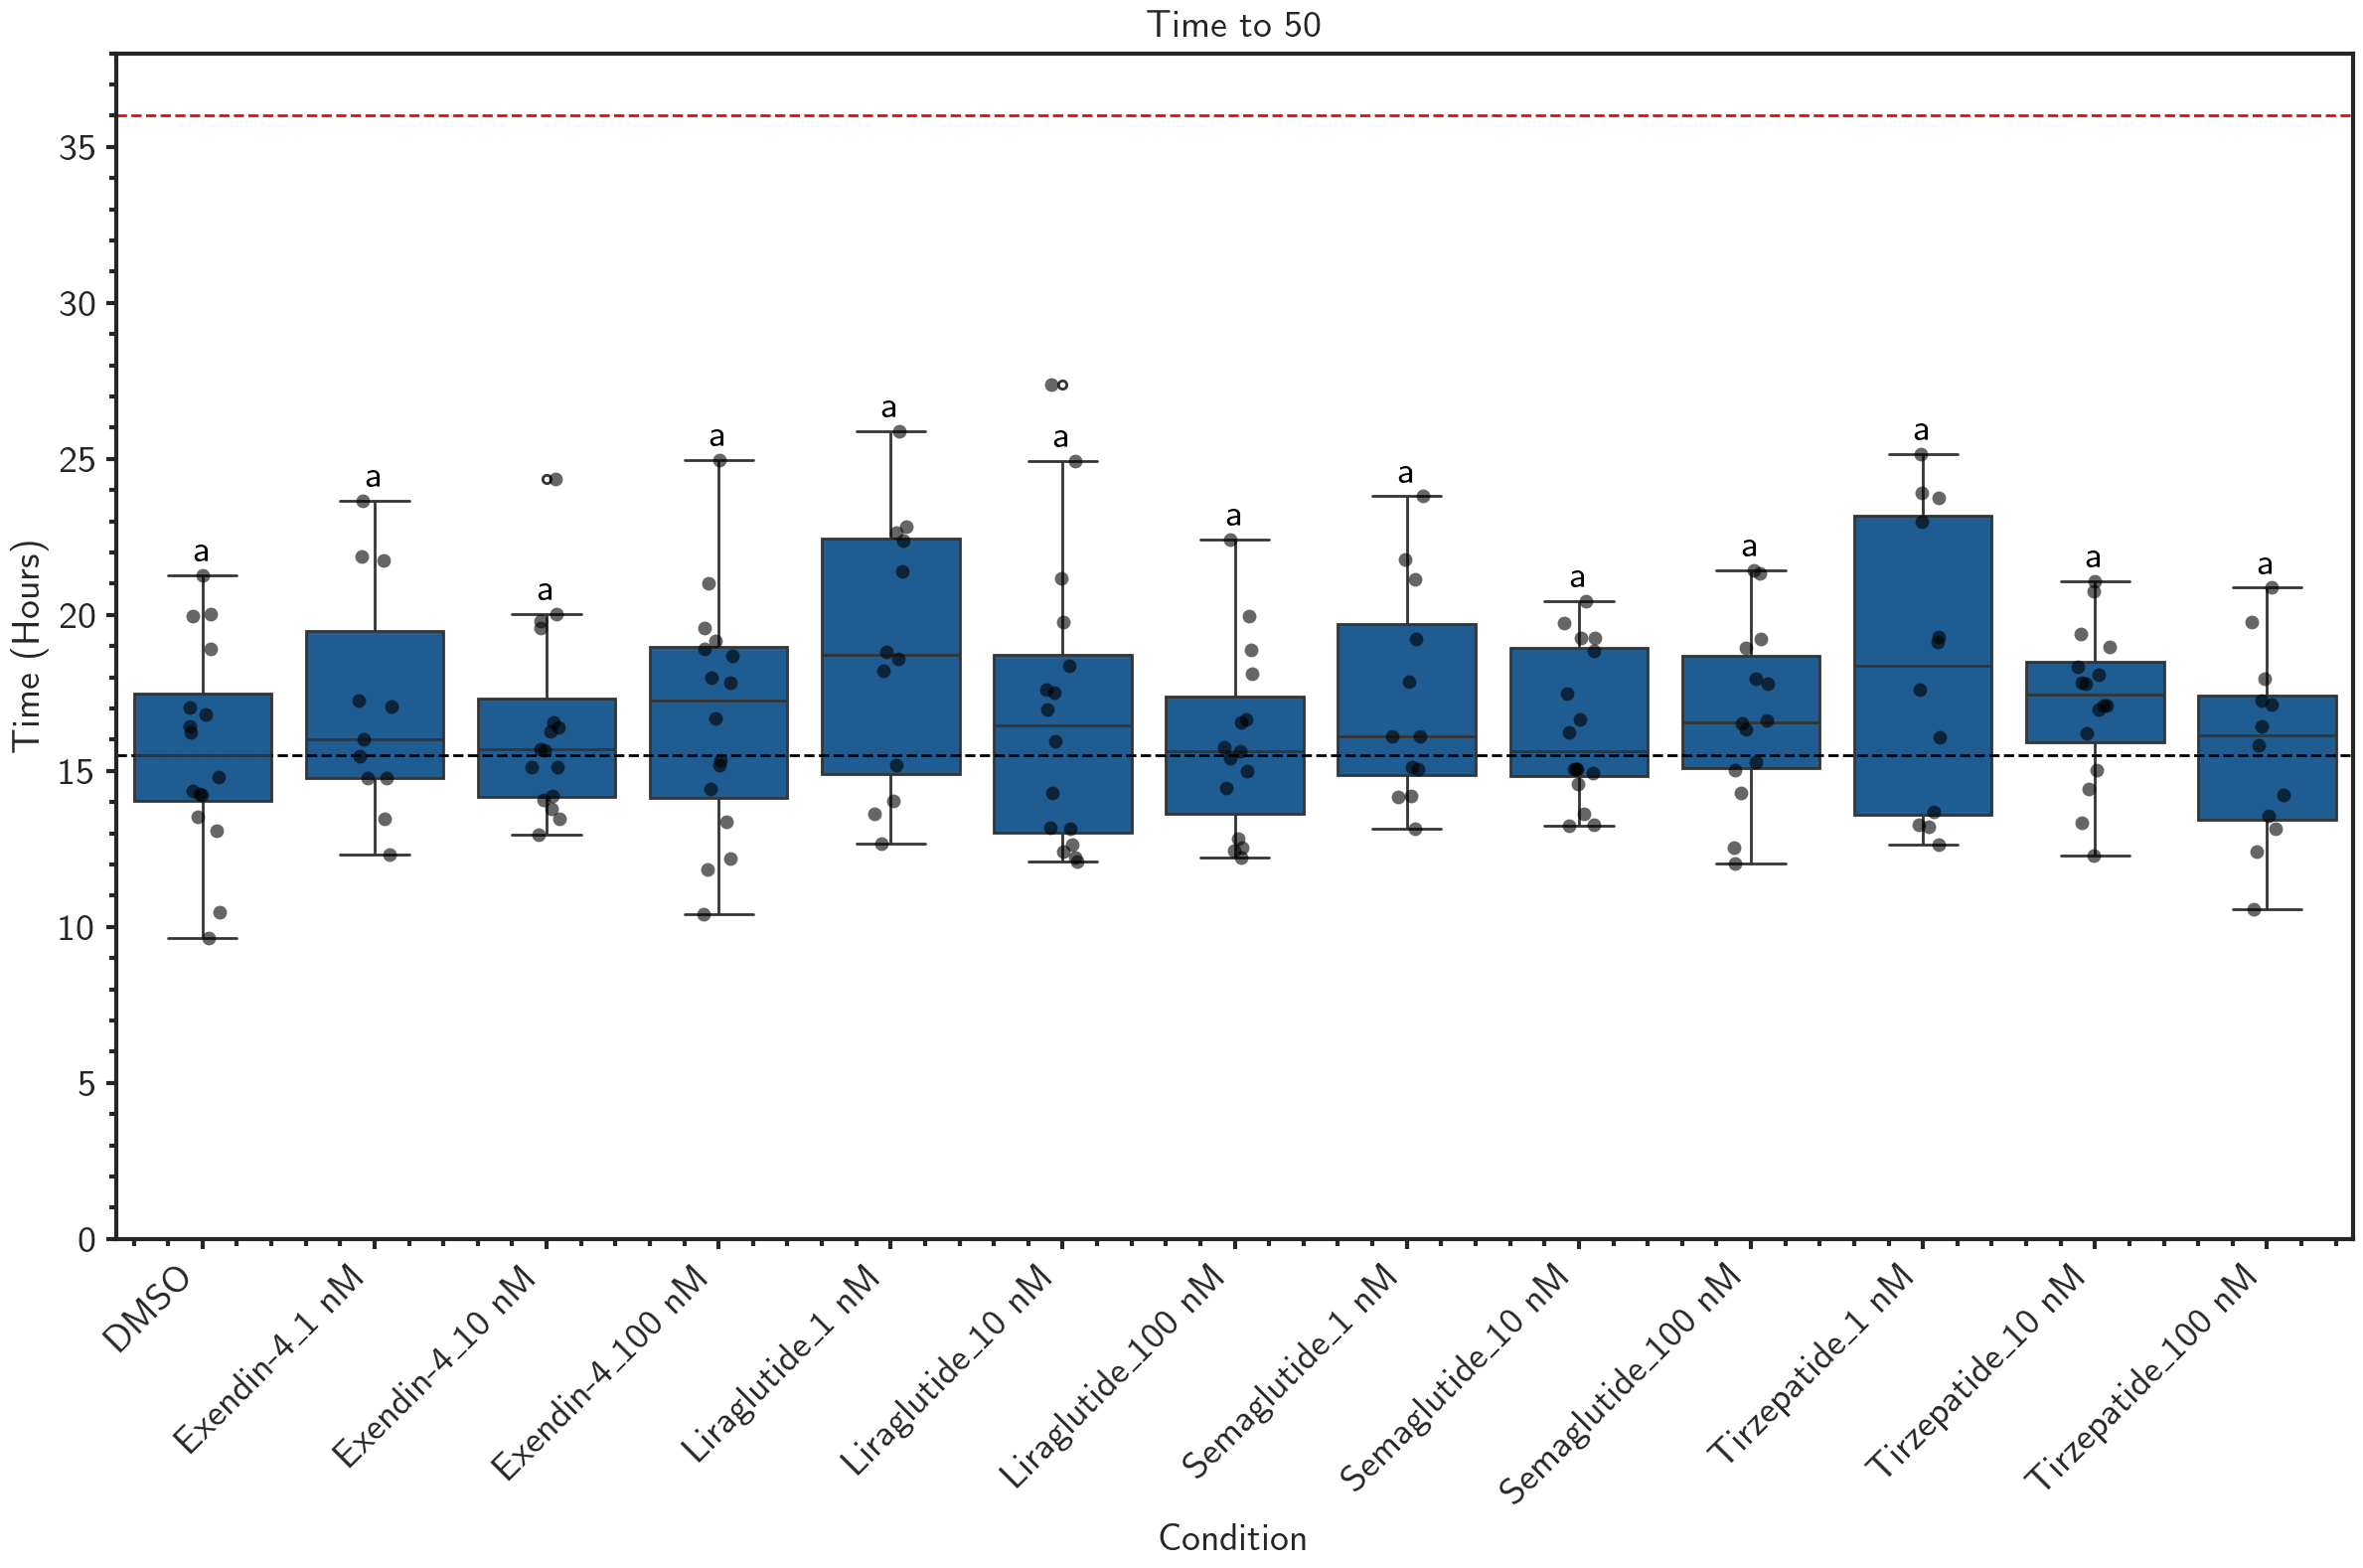

In [51]:
### Analysis Method 5: Time to 50% Closure (T50)
# This metric calculates the time required for each wound to heal to 50% of its initial area.
# A lower T50 value signifies a faster healing process. We use interpolation
# to get a precise estimate even if no data point falls exactly at 50%.
from scipy.stats import kruskal
import scikit_posthocs as sp
import cld4py

def calculate_t50(group):
    """Calculates the time to 50% closure for a single well."""
    # Ensure data is sorted by time
    group = group.sort_values('time_index')

    # Find the first point where area drops below 0.5
    if (group['wound_area_normalized'] <= 0.5).any():
        # Get the first index where condition is met
        first_half_idx = group[group['wound_area_normalized'] <= 0.5].index[0]

        # Get the index before it
        prev_idx = group.index[group.index.get_loc(first_half_idx) - 1]

        # Interpolate to find the exact time
        t1, a1 = group.loc[prev_idx, ['time_index', 'wound_area_normalized']]
        t2, a2 = group.loc[first_half_idx, ['time_index', 'wound_area_normalized']]

        # Avoid division by zero if areas are the same
        if a1 == a2:
            return t1

        # Linear interpolation: t = t1 + (t2 - t1) * (target_area - a1) / (a2 - a1)
        t50 = t1 + (t2 - t1) * (0.5 - a1) / (a2 - a1)
        return t50
    else:
        # Return NaN if the wound never closes to 50%
        return 36


# Calculate T50 for each well
t50_data = reshaped_data.groupby(['well', 'condition_map', 'exp']).apply(calculate_t50).reset_index(name='t50')

# Kruskal-Wallis test across conditions
groups = [group['t50'].values for name, group in t50_data.groupby('condition_map')]
kruskal_stat, kruskal_p = kruskal(*groups)
print(f"Kruskal-Wallis H-statistic: {kruskal_stat:.4f}, p-value: {kruskal_p:.4e}")

# Post-hoc Dunn's test with Bonferroni correction
dunn_results = sp.posthoc_dunn(t50_data, val_col='t50', group_col='condition_map', p_adjust='bonferroni')

# Prepare pairwise p-values in long format for cld4py
pairs = []
conditions = dunn_results.index.tolist()
for i, cond1 in enumerate(conditions):
    for j, cond2 in enumerate(conditions):
        if j > i:
            pval = dunn_results.loc[cond1, cond2]
            pairs.append({'group1': cond1, 'group2': cond2, 'p_value': pval})
pairwise_df = pd.DataFrame(pairs)

# Generate compact letter display with cld4py.assign_letters
letters = cld4py.assign_letters(pairwise_df, 'group1', 'group2', 'p_value', alpha=0.05,
                               order=ordered_conditions, data=t50_data, vals='t50', group='condition_map')

# Plot with CLD annotations
plt.figure(figsize=(12, 8))
ax = sns.boxplot(data=t50_data, x='condition_map', y='t50', order=ordered_conditions)
sns.stripplot(data=t50_data, x='condition_map', y='t50', color='0', alpha=0.6, order=ordered_conditions)

# Add CLD letters to the plot using cld4py.plot_letters
cld4py.plot_letters(cld=letters, data=t50_data, figax=ax, axis='x', plot='boxplot',
                    pos='upper', vals='t50', group='condition_map', pad=1, c='black')

# Add horizontal median line for reference (DMSO)
plt.axhline(y=t50_data.loc[t50_data['condition_map'] == 'DMSO', 't50'].median(), color='black', linestyle='--')

plt.axhline(y=36, color='r', linestyle='--', label='Never closes <50%')
plt.title('Time to 50% Wound Closure (T50)')
plt.ylabel('Time (Hours)')
plt.ylim(0,38)
plt.xlabel('Condition')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('Time to 50% Wound Closure (T50).svg')
plt.show()